# Neural Networks for MNIST dataset

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Loading MNIST
Here we load the dataset and create data loaders.

In [4]:
train_ds = datasets.MNIST('data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_ds = datasets.MNIST('data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/Users/yannetinterian/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629449223/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
batch_size = 32
#batch_size = 5 # for testing
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)

## Looking at Examples

In [7]:
train_dl = iter(train_loader)
x, y = next(train_dl)

In [8]:
print(x.shape, y.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


Looking are images

In [9]:
def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [10]:
# first from torch to numpy
X = x.numpy(); Y = y.numpy()
X.shape

(32, 1, 28, 28)

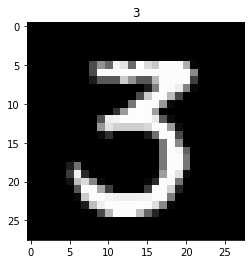

In [11]:
show(X[0][0], Y[0])

In [12]:
print(X[0][0][:4][:4])

[[-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421

## Feed Forward Neural Network

In [13]:
# for the number of neurons in the hidden unit
def get_model(M = 300):
    net = nn.Sequential(nn.Linear(28*28, M),
                        nn.ReLU(),
                        nn.Linear(M, 10))
    return net #.cuda()

In [22]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    model.train()
    for epoch in range(num_epochs):
        sum_loss = 0.0
        total = 0
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = images.view(-1, 28*28) #.cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.item()
                
        train_loss = sum_loss/total
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
    return val_acc, val_loss, train_loss

In [23]:
def model_accuracy_loss(model, test_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28)  #.cuda()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.item()
        total += labels.size(0)
        correct += pred.eq(labels.data).sum().item()
    return 100 * correct / total, sum_loss/ total

In [24]:
net = get_model()
learning_rate = 0.01
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
model_accuracy_loss(net, test_loader)

(7.04, 2.3412227783203123)

In [26]:
val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=2, model=net, optimizer=optimizer)

Epoch [1/2], Loss: 0.2512
Epoch [1/2], Valid Accuracy: 94.2700, Valid Loss: 0.2195
Epoch [2/2], Loss: 0.2363
Epoch [2/2], Valid Accuracy: 93.7200, Valid Loss: 0.2751


## Models with L2 regularization
To add L2 regularization use the `weight_decay` argument on the optimizer

In [18]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 0.01)

## Models with Dropout

In [19]:
def get_model_v2(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 10))
    return nn.Sequential(*modules) #.cuda()

In [20]:
net = get_model_v2(M = 300, p=0.1)
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [21]:
train_model(train_loader, test_loader, num_epochs=4, model=net, optimizer=optimizer)

Epoch [1/4], Loss: 0.7422
Epoch [1/4], Loss: 0.5880
Epoch [1/4], Loss: 0.5494
Epoch [1/4], Loss: 0.5195
Epoch [1/4], Loss: 0.5020
Epoch [1/4], Loss: 0.4917
Epoch [1/4], Loss: 0.4791
Epoch [1/4], Loss: 0.4672
Epoch [1/4], Loss: 0.4643
Epoch [1/4], Loss: 0.4618
Epoch [1/4], Loss: 0.4566
Epoch [1/4], Loss: 0.4517
Epoch [1/4], Loss: 0.4441
Epoch [1/4], Loss: 0.4386
Epoch [1/4], Loss: 0.4337
Epoch [1/4], Loss: 0.4328
Epoch [1/4], Loss: 0.4282
Epoch [1/4], Loss: 0.4277
Epoch [1/4], Loss: 0.4256
Epoch [1/4], Valid Accuracy: 91.4200, Valid Loss: 0.3112
Epoch [2/4], Loss: 0.4166
Epoch [2/4], Loss: 0.4097
Epoch [2/4], Loss: 0.4042
Epoch [2/4], Loss: 0.3971
Epoch [2/4], Loss: 0.3909
Epoch [2/4], Loss: 0.3853
Epoch [2/4], Loss: 0.3809
Epoch [2/4], Loss: 0.3765
Epoch [2/4], Loss: 0.3742
Epoch [2/4], Loss: 0.3706
Epoch [2/4], Loss: 0.3658
Epoch [2/4], Loss: 0.3628
Epoch [2/4], Loss: 0.3604
Epoch [2/4], Loss: 0.3575
Epoch [2/4], Loss: 0.3552
Epoch [2/4], Loss: 0.3520
Epoch [2/4], Loss: 0.3490
Epoch [

(93.55, 0.301843672710564, 0.3010863176873885)